Loading Dependencies:

In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv 
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory

Check if GPU is available:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18159796545522834859
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732564992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5903201762456990444
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


#  Importing the data
## Trying out another method

In [3]:
# All the folders in the training directory
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dir = "./data/Training/"
test_dir = "./data/Testing/"

# Initialize image & batch size
IMG_SIZE = 300
batch_size = 20

In [4]:
# Augment training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        height_shift_range=0.1,
        width_shift_range=0.1,
        brightness_range=(0.5,1.5),
        zoom_range = [1, 1.5],
      )

# No augmentation on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate with flow from directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        color_mode='rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')

# Generate with flow from directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        color_mode='rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
keys = train_generator.class_indices
keys

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [6]:
def get_key(val):
    for key, value in keys.items():
        if val == value:
            return key
 
    return "key doesn't exist"


get_key(0)

'glioma_tumor'

Showing some of the augmented images:

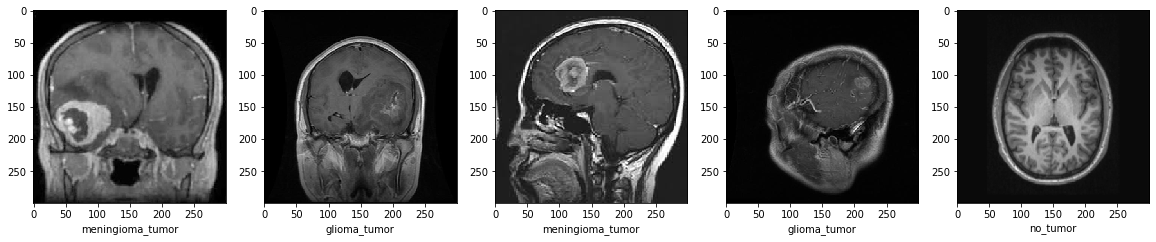

In [7]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = train_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Showing some unaugmented pictures:

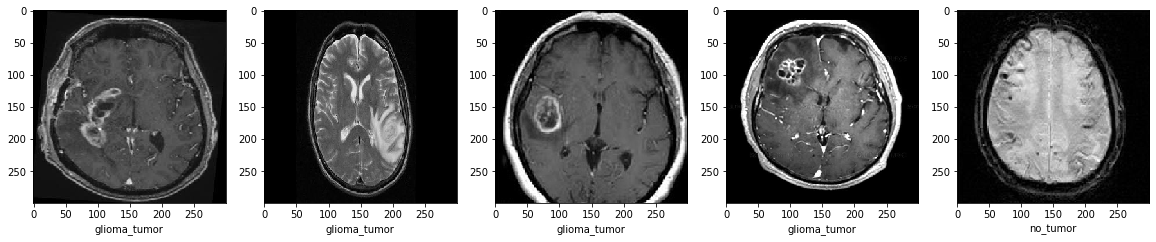

In [8]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = test_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Shuffle the data since otherwise the neural network doesn't learn very well:

Create the training/testing Y & X:

In [28]:
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(300, 300, 3),
    include_top=False)

base_model.trainable = False

In [32]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 300, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(4, activation = "softmax")
])

# Building the Neural Network

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [34]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 10) 

Epoch 1/10


C:\Users\felix\AppData\Local\Temp\ipykernel_1376\694823855.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 10)


143/143 [==============================] - 12s 73ms/step - loss: 0.9651 - accuracy: 0.6744 - val_loss: 1.2608 - val_accuracy: 0.6526
Epoch 2/10
143/143 [==============================] - 9s 65ms/step - loss: 0.3305 - accuracy: 0.8786 - val_loss: 1.2652 - val_accuracy: 0.7605
Epoch 3/10
143/143 [==============================] - 9s 66ms/step - loss: 0.1812 - accuracy: 0.9344 - val_loss: 1.3718 - val_accuracy: 0.7553
Epoch 4/10
143/143 [==============================] - 9s 66ms/step - loss: 0.1155 - accuracy: 0.9614 - val_loss: 1.3025 - val_accuracy: 0.7816
Epoch 5/10
143/143 [==============================] - 9s 65ms/step - loss: 0.0817 - accuracy: 0.9716 - val_loss: 1.4600 - val_accuracy: 0.7842
Epoch 6/10
143/143 [==============================] - 9s 65ms/step - loss: 0.0639 - accuracy: 0.9793 - val_loss: 1.3973 - val_accuracy: 0.7947
Epoch 7/10
143/143 [==============================] - 9s 65ms/step - loss: 0.0428 - accuracy: 0.9895 - val_loss: 1.6295 - val_accuracy: 0.8000
Epoch 8/1

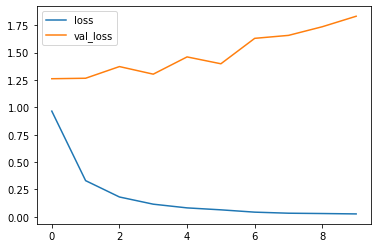

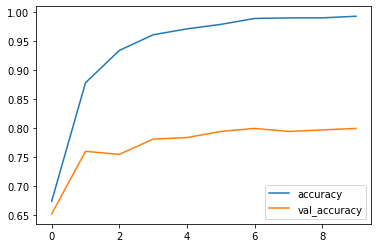

In [36]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
